In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
import plotly.express as px

In [4]:
from scipy.stats import normaltest
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

In [6]:
dat = pd.read_csv('stroke_data.csv')  # Read original dataset
d = dat.copy()  # backup
print(d.shape)

(5110, 12)


In [7]:
d.drop(columns=['id'], inplace=True)  # ID item has nothing to do with subsequent analysis
print(d.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB
None


In [8]:
print(d.describe())

               age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  4909.000000  5110.000000  
mean     28.893237     0.048728  
std       7.854067     0.215320  
min      10.300000     0.000000  
25%      23.500000     0.000000  
50%      28.100000     0.000000  
75%      33.100000     0.000000  
max      97.600000     1.000000  


In [9]:
def missing_data_table(data):  #The parameter data represents the data set to be processed
    t = data.isnull().sum().sort_values(ascending=False)  # Number of missing values for each variable in the dataset
    p = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)  # Proportion of missing values
    missing_data = pd.concat([t, p], axis=1, keys=['total', 'percent'])
    return missing_data
print(missing_data_table(d))

                   total   percent
bmi                  201  0.039335
gender                 0  0.000000
age                    0  0.000000
hypertension           0  0.000000
heart_disease          0  0.000000
ever_married           0  0.000000
work_type              0  0.000000
Residence_type         0  0.000000
avg_glucose_level      0  0.000000
smoking_status         0  0.000000
stroke                 0  0.000000


In [10]:
d = d.fillna(np.mean(d['bmi']))  # Use average to fill missing

In [11]:
d_n = d[['age', 'avg_glucose_level', 'bmi']]
d_c = d[['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']]  # 分类变量

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


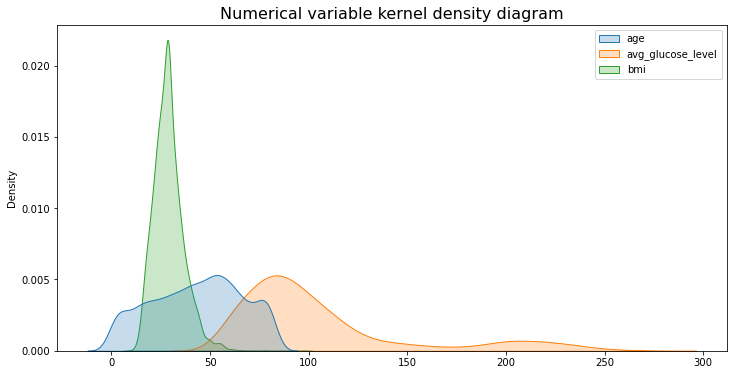

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=d_n, shade=True)  # Plot the kernel density of numerical variables
plt.title('Numerical variable kernel density diagram', fontproperties='SimHei', fontsize=16)
plt.show()

In [13]:
sk = list()
for i in d_n.columns:
   # Calculate the kurtosis and skewness of each numerical variable, and test the normality based on kurtosis and skewness
   sk.append([i,d_n[i].skew(),d_n[i].kurt(),list(normaltest(d_n[i]))[0],list(normaltest(d_n[i]))[1]])  
sk_result = pd.DataFrame(sk, columns=['Variable name', 'skewness', 'kurtosis', 'statistic', 'P value']) 
print(sk_result)

       Variable name  skewness  kurtosis    statistic        P value
0                age -0.137059 -0.991010  1120.528644  4.789570e-244
1  avg_glucose_level  1.572284  1.680479  1328.935795  2.662311e-289
2                bmi  1.076716  3.623061  1110.536916  7.079012e-242


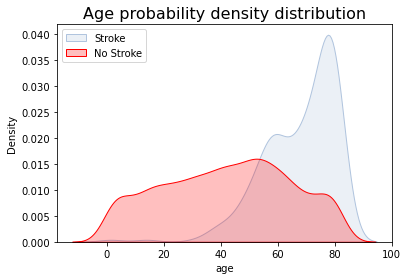

In [14]:
# Age probability density distribution
sns.kdeplot(d.loc[d['stroke'] == 1]['age'], color='#B0C4DE', label='Stroke', shade=True)
sns.kdeplot(d.loc[d['stroke'] == 0]['age'], color='#FF0000', label='No Stroke', shade=True)
plt.title('Age probability density distribution', fontproperties='SimHei', fontsize=16)
plt.legend(loc=2)
plt.show()

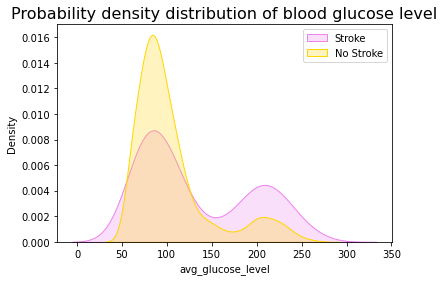

In [15]:
# Probability density distribution of blood glucose level
sns.kdeplot(d.loc[d['stroke']==1]['avg_glucose_level'],color='#EE82EE',label='Stroke',shade=True)
sns.kdeplot(d.loc[d['stroke']==0]['avg_glucose_level'],color='#FFD700',label='No Stroke',shade=True)
plt.title('Probability density distribution of blood glucose level', fontproperties='SimHei', fontsize=16)
plt.legend(loc=1)
plt.show()

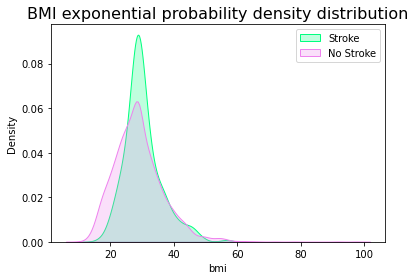

In [16]:
# BMI exponential probability density distribution
sns.kdeplot(d.loc[d['stroke'] == 1]['bmi'], color='#00FF7F', label='Stroke', shade=True)
sns.kdeplot(d.loc[d['stroke'] == 0]['bmi'], color='#EE82EE', label='No Stroke', shade=True)
plt.title('BMI exponential probability density distribution', fontproperties='SimHei', fontsize=16)
plt.legend(loc=1)
plt.show()

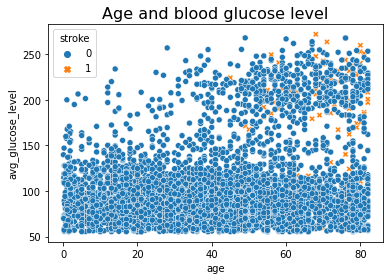

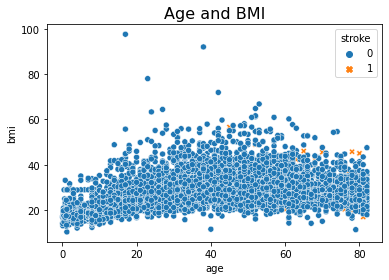

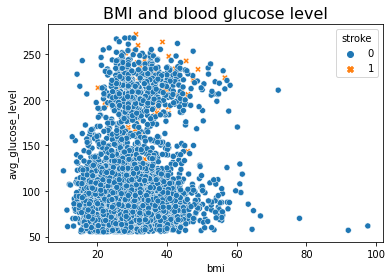

In [17]:
# Age and blood glucose level
sns.scatterplot(x=d_n['age'], y=d_n['avg_glucose_level'], hue=d_c['stroke'], style=d_c['stroke'])
plt.title('Age and blood glucose level', fontproperties='SimHei', fontsize=16)
plt.show()
# Age and BMI
sns.scatterplot(x=d_n['age'], y=d_n['bmi'], hue=d_c['stroke'], style=d_c['stroke'])
plt.title('Age and BMI', fontproperties='SimHei', fontsize=16)
plt.show()
# BMI and blood glucose level
sns.scatterplot(x=d_n['bmi'], y=d_n['avg_glucose_level'], hue=d_c['stroke'], style=d_c['stroke'])
plt.title('BMI and blood glucose level', fontproperties='SimHei', fontsize=16)
plt.show()

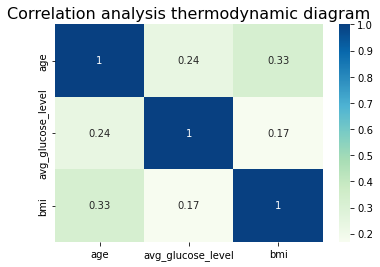

In [18]:
# Correlation analysis thermodynamic diagram
num_cor = d_n.corr()  # Calculate the correlation coefficient between two variables
sns.heatmap(data=num_cor, annot=True, cmap='GnBu')
plt.title('Correlation analysis thermodynamic diagram', fontproperties='SimHei', fontsize=16)
plt.show()

/Users/wanghaoze/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/wanghaoze/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/wanghaoze/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


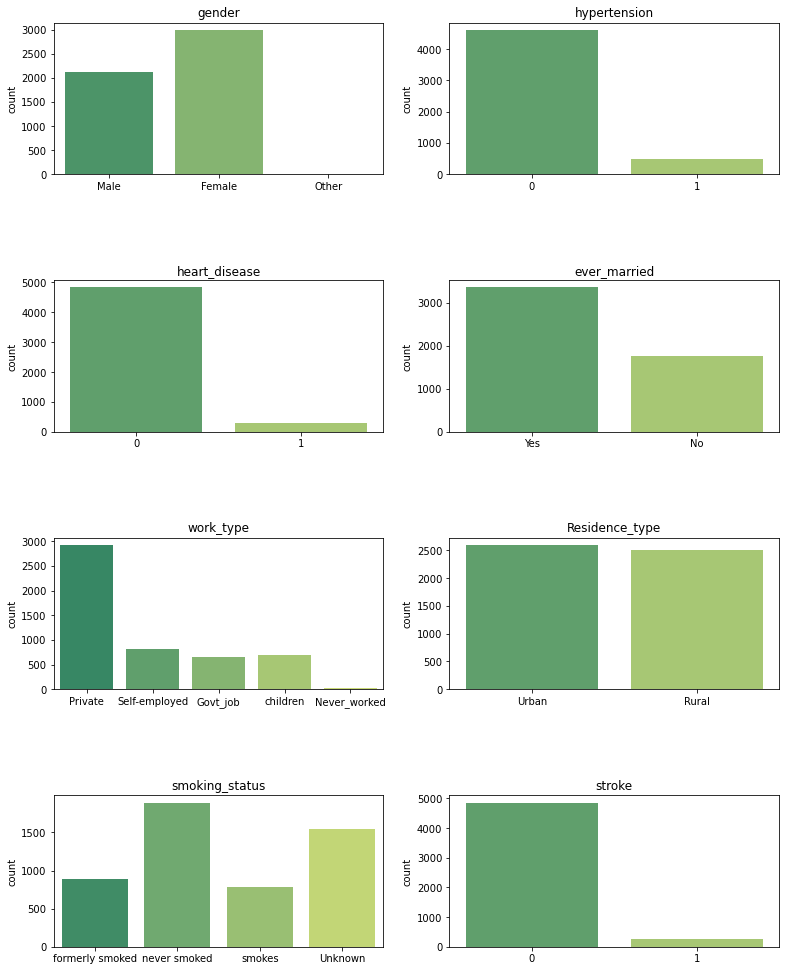

In [19]:
fig = plt.figure(figsize=(13, 17))
for a, b in enumerate(d_c.columns):
    ax = plt.subplot(4, 2, a+1)
    ax.set_title(b)
    sns.countplot(d_c[b], palette='summer')  # Draw bar chart of each category variable
    ax.set_xlabel('')
plt.subplots_adjust(hspace=0.7)
plt.show()

/Users/wanghaoze/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/wanghaoze/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/wanghaoze/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


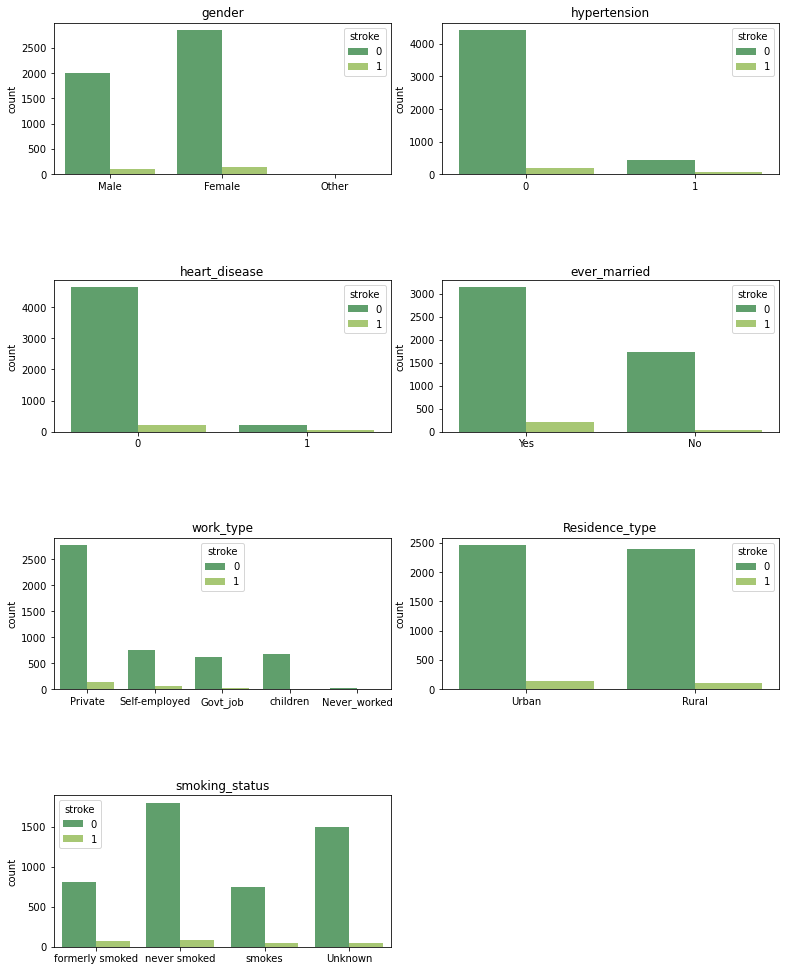

In [20]:
cata_d= d_c[['gender', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'smoking_status']]
fig = plt.figure(figsize=(13, 17))
for a, b in enumerate(cata_d.columns):
    ax = plt.subplot(4, 2, a+1)
    ax.set_title(b)
    sns.countplot(cata_d[b], palette='summer', hue=d_c['stroke'])  #Parameter hue is used to divide stroke samples
    ax.set_xlabel('')
plt.subplots_adjust(wspace=0.15, hspace=0.7)
plt.show()

In [21]:
for i in np.arange(d_c.shape[1] - 1):
    cross_table = pd.crosstab(d_c.iloc[:, i], d_c['stroke'], margins=True)
    x2, p, df, _ = chi2_contingency(cross_table) #Direct substitution for chi square
    print(d_c.columns[i], x2, p)

gender 0.47258662884530234 0.9981562670127478
hypertension 83.59647297303054 3.0108035176944244e-17
heart_disease 93.01112941392964 3.0174102060790215e-19
ever_married 59.978623069992466 2.9310242542472095e-12
work_type 49.163511976675295 3.8016089152551844e-07
Residence_type 1.2210278401168941 0.8746245355079243
smoking_status 29.147269191399268 0.0002987690540643257


In [22]:
print(d)

      gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1     Female  61.0             0              0          Yes  Self-employed   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
5105  Female  80.0             1              0          Yes        Private   
5106  Female  81.0             0              0          Yes  Self-employed   
5107  Female  35.0             0              0          Yes  Self-employed   
5108    Male  51.0             0              0          Yes        Private   
5109  Female  44.0             0              0          Yes       Govt_job   

     Residence_type  avg_glucose_level        bmi  

In [23]:
pd.get_dummies(d)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.600000,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,28.893237,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.500000,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.400000,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.000000,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.893237,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
5106,81.0,0,0,125.20,40.000000,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
5107,35.0,0,0,82.99,30.600000,0,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
5108,51.0,0,0,166.29,25.600000,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


In [24]:
d['gender'] = d['gender'].apply(lambda x: 1 if x == 'Male' else 0)  # Assign values to binary variables in the original data
d['ever_married'] = d['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)
d['Residence_type'] = d['Residence_type'].apply(lambda x: 1 if x == 'Urban' else 0) 
d = d[d['smoking_status'] != 'Unknown']  # Delete the data of smoking history variable 'unknown'
# Using map mapping function to classify multiple variables
d['smoking_status'] = d['smoking_status'].map({'smokes': 2, 'formerly smoked': 1, 'never smoked': 0}) 
d['work_type'] = d['work_type'].map({'Private': 4, 'Self-employed': 3, 'Govt_job': 2, 'Never_worked': 1, 'children': 0}) 


findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


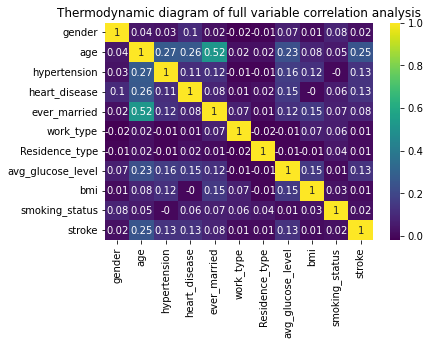

In [25]:
var_cor = round(d.corr(), 2)  # Calculate correlation
sns.heatmap(data=var_cor, annot=True, cmap='viridis') 
plt.title('Thermodynamic diagram of full variable correlation analysis', fontproperties='SimHei', fontsize=12)
plt.show()

In [26]:
stroke = round(100 * d['stroke'].sum()/len(d['stroke']), 2) 
print(stroke)  # The proportion of stroke is only 5.66%, which is low.

5.66


In [27]:
train_set,test_set = train_test_split(d,stratify=d['stroke'], random_state=1) # 参数stratify用来指定按照中风变量进行分层抽样

In [28]:
train_set_y = train_set['stroke']           # Prepare the target variables of the training set
train_set_x = train_set.drop(columns=['stroke'])    # Prepare the characteristic variables of the training set
test_set_y = test_set['stroke']            # Prepare the target variables of the test set
test_set_x = test_set.drop(columns=['stroke'])    # Prepare the characteristic variables of the test set
scaler = StandardScaler()               # The characteristic variables of training set and test set are standardized
train_set_x = scaler.fit_transform(train_set_x)
test_set_x = scaler.transform(test_set_x)

In [29]:
smote=SMOTE()
train_set_x,train_set_y=smote.fit_resample(train_set_x,train_set_y)
test_set_x,test_set_y=smote.fit_resample(test_set_x,test_set_y)

In [30]:
print(train_set_x.shape,train_set_y.shape,test_set_x.shape,test_set_y.shape)

(5046, 10) (5046,) (1682, 10) (1682,)


In [31]:
train_set_y.to_csv("train_set_y.csv")
test_set_y.to_csv("test_set_y.csv")

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def model_eva(model, train_x, train_y, test_x, test_y):
    model.fit(train_x, train_y)
    score = model.score(test_x, test_y)
    pre = model.predict(test_x)
    print('The test set accuracy is：', score)
    cm = confusion_matrix(test_y, pre)
    ConfusionMatrixDisplay(cm).plot(cmap='YlOrRd')
    plt.show()

The test set accuracy is： 0.7193816884661117


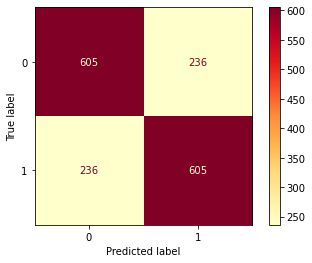

In [33]:
from sklearn.linear_model import LogisticRegression
logistic_fit = LogisticRegression()  # Build a logistic regression model object
model_eva(logistic_fit, train_set_x, train_set_y, test_set_x, test_set_y)  # Bring the built model along with the training and testing datasets into the function we created

The test set accuracy is： 0.8008323424494649


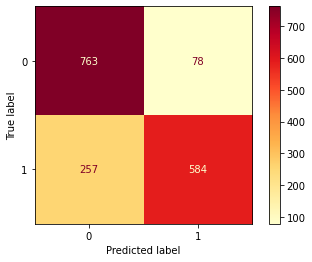

In [34]:
from sklearn.tree import DecisionTreeClassifier
dtc_fit = DecisionTreeClassifier(random_state=1)  # Build a decision tree model object
model_eva(dtc_fit, train_set_x, train_set_y, test_set_x, test_set_y)

The test set accuracy is： 0.5689655172413793


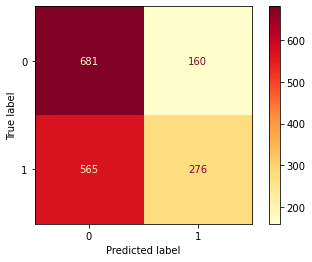

In [35]:
from sklearn.neighbors import KNeighborsClassifier
knc_fit = KNeighborsClassifier()  # Build k-neighbor model objects
model_eva(knc_fit, train_set_x, train_set_y, test_set_x, test_set_y)

The test set accuracy is： 0.683115338882283


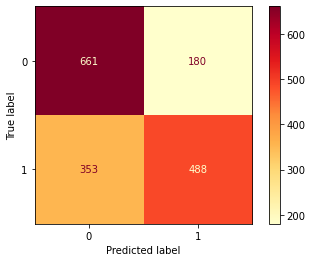

In [36]:
from sklearn.svm import SVC
svc_fit = SVC(kernel='rbf')  # Build the Support Vector Machine Model Object of Radial Basis Kernel Function
model_eva(svc_fit, train_set_x, train_set_y, test_set_x, test_set_y)

The test set accuracy is： 0.7752675386444708


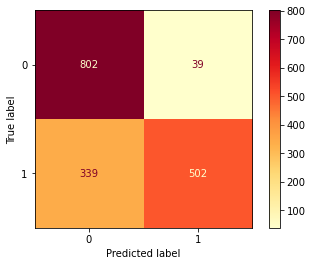

In [37]:
from sklearn.ensemble import RandomForestClassifier
rfc_fit = RandomForestClassifier(random_state=3)  # Build a random forest model object
model_eva(rfc_fit, train_set_x, train_set_y, test_set_x, test_set_y)

The test set accuracy is： 0.8573127229488704


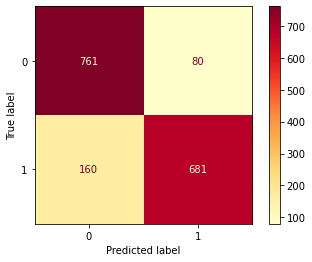

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_fit = GradientBoostingClassifier(random_state=6)  # Build a Gradient Boosting Algorithm Object
model_eva(gbc_fit, train_set_x, train_set_y, test_set_x, test_set_y)

The test set accuracy is： 0.7128418549346016


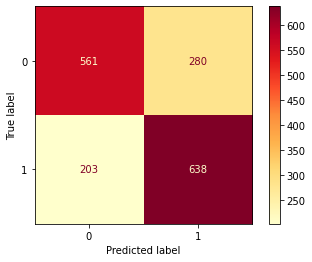

In [39]:
from sklearn.linear_model import SGDClassifier
sgd_fit = SGDClassifier(random_state=12)  # Build Gradient Descent Algorithm Object
model_eva(sgd_fit, train_set_x, train_set_y, test_set_x, test_set_y)

In [40]:
from sklearn import metrics
def roc_com(names, models, colors, train_x, train_y, test_x, test_y):
# Among the model parameters, names, models and colors are in list format, which store the name of the model, model class and line color respectively; the last four parameters are the feature variables of the training set, the target variables and the features of the test set.
    plt.figure(figsize=(12, 12))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    for (name, model, color) in zip(names, models, colors):
        model.fit(train_x, train_y)  
        pre_prob = model.predict_proba(test_x)[:, 1]  # The probability that the test set is predicted to be positive by the classifier
        fpr, tpr, thresholds = metrics.roc_curve(test_y, pre_prob, pos_label=1)  # Calculate false positive rate, true positive rate and threshold
        model_auc = round(metrics.auc(fpr, tpr), 3)
        plt.plot(fpr, tpr, lw=3, label=f'{name}AUC={model_auc}', color=color)
    plt.plot([0, 1], [0, 1], '--', lw=3, color='black')
    plt.axis('square')
    plt.xlabel('false positive rate', fontsize=15)
    plt.ylabel('true positive rate', fontsize=15)
    plt.title('Comparison of ROC curves of various models', fontsize=20)
    plt.legend(loc='lower right', fontsize=15)
    plt.show()


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


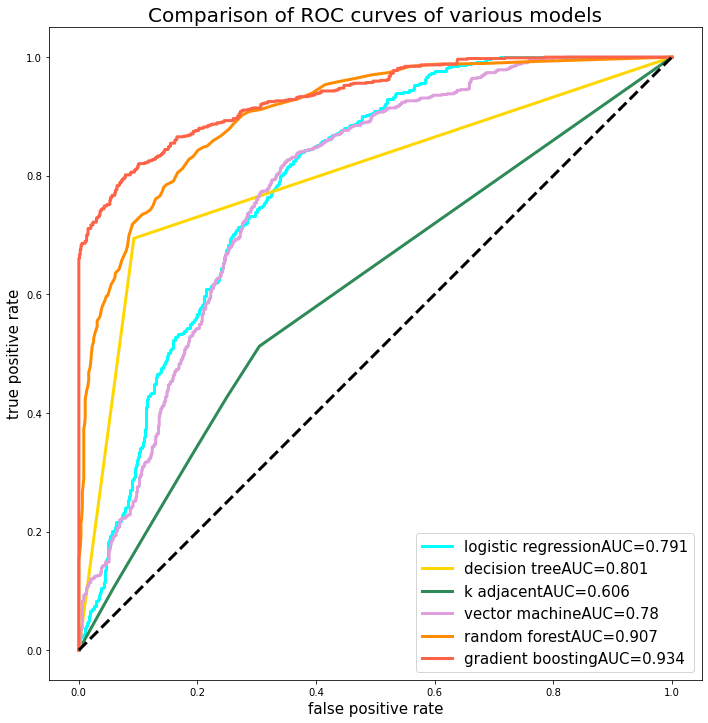

In [41]:

logistic_fit = LogisticRegression()  # Objects for building logistic regression models
dtc_fit = DecisionTreeClassifier(random_state=1)  # Build a decision tree model object
knc_fit = KNeighborsClassifier()  # BUild k-neighbor model objects
svc_fit = SVC(kernel='rbf', probability=True)  # Build the Support Vector Machine Model Object of Radial Basis Kernel Function
rfc_fit = RandomForestClassifier(random_state=3)  # Build a random forest model object
gbc_fit = GradientBoostingClassifier(random_state=6)  # Build a gradient boosting algorithm model object
model_name = ['logistic regression', 'decision tree', 'k adjacent', 'vector machine', 'random forest', 'gradient boosting', 'gradient descent']  # A list of model names
model_type = [logistic_fit, dtc_fit, knc_fit, svc_fit, rfc_fit, gbc_fit]  # A list of model objects (the SGDC classifier model SGDClassifier is not selected in the list)，
# Because the loss function defaults to the hinge function, the probability of the predicted value cannot be obtained. It needs to be calibrated by CalibratedClassifierCV to calculate the probability value of the former)
roc_color = ['cyan', 'gold', 'seagreen', 'plum', 'darkorange', 'tomato']  # A list of line colors
roc_com(model_name, model_type, roc_color, train_set_x, train_set_y, test_set_x, test_set_y)
